In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import cv2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torch.nn.functional as F
from torch.utils.data.sampler import Sampler

from pathlib import Path
import sys
from IPython.display import display

import pydicom
import glob

import time
import datetime 
from tqdm import tqdm 

from copy import deepcopy
# from torchkeras.metrics import Accuracy

In [3]:
# helper to transform rle to mask img
from mask_functions import rle2mask
from skimage.color import label2rgb

In [61]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


# Primary Model

In [2]:
class convBlock(nn.Module):
    def __init__(self, input_channel, output_channel):
        super(convBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channel, output_channel, 3)
        self.conv2 = nn.Conv2d(output_channel, output_channel, 3)
        self.relu = nn.ReLU()
    
    def forward(self, input:torch.tensor):
        input = self.conv1(input)
        input = self.relu(input)
        input = self.conv2(input)
        return input


In [3]:
class UnetEncoder(nn.Module):
    def __init__(self, channel_list:list):
        super(UnetEncoder, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.block_list = []

        for i in range(len(channel_list)-1):
            self.block_list.append(convBlock(channel_list[i], channel_list[i+1]))
    
    def forward(self, input:torch.tensor):
        layered_encoder_out = []

        for block in self.block_list:
            input = block(input)
            layered_encoder_out .append(input)
            input = self.pool(input)

        return layered_encoder_out 

In [4]:
class UnetDecoder(nn.Module):
    def __init__(self, channel_list:list):
        super(UnetDecoder, self).__init__()
        self.channel_list = channel_list
        self.block_list = []
        self.up_sampler = []

        for i in range(len(channel_list)-1):
            self.up_sampler.append(nn.ConvTranspose2d(channel_list[i], channel_list[i+1], 2, 2))

        for i in range(len(channel_list)-1):
            self.block_list.append(convBlock(channel_list[i], channel_list[i+1]))

    # layer concat takes from the encoder layered ouptut for concat
    def forward(self, input, layered_concat):
        for i in range(len(self.channel_list)-1):
            input = self.up_sampler[i](input)
            concat_feature = self.crop(layered_concat[i], input)
            input = torch.concat([input, concat_feature], dim=1)
            input = self.block_list[i](input)
        return input

    def crop(self, concat_feature, input):
            B, C, H, W = input.shape
            concat_feature = torchvision.transforms.CenterCrop([H, W])(concat_feature)
            return concat_feature


In [5]:
class UNET(nn.Module):
    def __init__(self, in_channel_list:list, out_channel_list:list, classes=1, keep_dim=True, output_size=(1024, 1024)):
        super(UNET, self).__init__()
        self.encoder = UnetEncoder(in_channel_list)
        self.decoder = UnetDecoder(out_channel_list)
        self.compressor = nn.Conv2d(out_channel_list[-1], classes, 1)
        self.output_size = output_size
        self.keep_dim = keep_dim
    
    def forward(self, input):
        encoder_output = self.encoder(input)
        encoder_output = list(reversed(encoder_output))
        output = self.decoder(encoder_output[0], encoder_output[1:])
        output = self.compressor(output)
        if self.keep_dim:
            output = F.interpolate(output, self.output_size)
        return output


In [6]:
enc_block = convBlock(1, 64)
x = torch.randn(1, 1, 572, 572)
x = enc_block(x)
display(x.shape)

torch.Size([1, 64, 568, 568])

In [7]:
chan_list = [3,64,128,256,512,1024]
encoder = UnetEncoder(channel_list=chan_list)
# input image
x    = torch.randn(1, 3, 572, 572)
ftrs = encoder(x)
for ftr in ftrs: print(ftr.shape)

torch.Size([1, 64, 568, 568])
torch.Size([1, 128, 280, 280])
torch.Size([1, 256, 136, 136])
torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 28, 28])


In [8]:
channel_list = [1024, 512, 256, 128, 64]
decoder = UnetDecoder(channel_list=channel_list)
x = torch.randn(1, 1024, 28, 28)
decoder(x, ftrs[::-1][1:]).shape

torch.Size([1, 64, 388, 388])

In [9]:
in_chan = [3,64,128,256,512,1024]
out_chan = [1024, 512, 256, 128, 64]
unet = UNET(in_chan, out_chan, keep_dim=True)
x    = torch.randn(1, 3, 572, 572)
unet(x).shape

torch.Size([1, 1, 1024, 1024])

# Data Processing

In [4]:
work_folder = r'D:\UT_Third_Year\UT_TY_Fall\APS360\Segmentation_data\archive'
train_data_path = r'D:\UT_Third_Year\UT_TY_Fall\APS360\Segmentation_data\archive\dicom-images-train'
train_data_path = Path(train_data_path)
work_folder = Path(work_folder)

In [5]:
train_rle_path = work_folder / 'train-rle.csv'
train_rle = pd.read_csv(train_rle_path)

In [6]:
display(train_rle)

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...
...,...,...
11577,1.2.276.0.7230010.3.1.4.8323329.4461.151787518...,592067 6 1016 10 1012 14 1007 18 1004 20 1003...
11578,1.2.276.0.7230010.3.1.4.8323329.4461.151787518...,610576 3 1001 38 981 53 966 63 956 73 947 87 ...
11579,1.2.276.0.7230010.3.1.4.8323329.32730.15178751...,-1
11580,1.2.276.0.7230010.3.1.4.8323329.13252.15178752...,-1


In [7]:
image_height = 1024
image_width = 1024
channel_num = 1

In [8]:
# loader the level 1 of folder hierarchy
level1_folder = glob.glob(f"{train_data_path}/*")

In [9]:
# load level 2 folder hierarchy
level2_folder = []
for idx, path in enumerate(level1_folder):
    level2_folder.append(glob.glob(f"{path}/*"))

In [10]:
# load the dicom file path at 3 level hierarchy
dicom_file_path = []
for i in range(len(level2_folder)):
    dicom_file_path.append(glob.glob(f"{level2_folder[i][0]}/*.dcm"))

' 303547 8 1010 15 1006 20 1001 24 998 27 995 30 992 32 990 35 986 38 984 41 981 43 980 44 979 45 978 46 977 47 976 48 976 48 975 49 975 49 975 49 974 50 974 50 974 50 975 49 980 44 985 38 990 34 995 28 1001 22 1006 17 1012 11 1018 5'

(1024, 1024)

(1024, 1024)

(512, 512)
(512, 512)


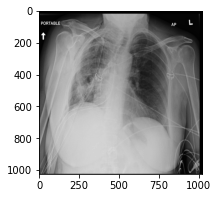

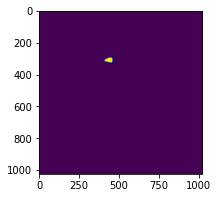

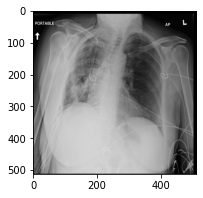

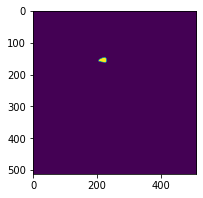

In [11]:
# down sample
from scipy.ndimage.interpolation import zoom

temp = pydicom.dcmread(f"{dicom_file_path[1000][0]}").pixel_array
img_id = pydicom.dcmread(f"{dicom_file_path[1000][0]}").file_meta[(2,3)].value
label_mask = train_rle.loc[train_rle['ImageId'] == img_id][' EncodedPixels']
label_mask = label_mask.values[0]
display(label_mask)

mask_img = rle2mask(label_mask, image_height, image_width)

display(mask_img.shape)
display(temp.shape)

plt.figure(figsize=(3,3))
plt.imshow(temp, cmap='gray')
plt.figure(figsize=(3,3))
plt.imshow(mask_img)

data_img = zoom(temp, zoom = 0.5, order=1)
mask_img = zoom(mask_img, zoom = 0.5, order=1)
print(data_img.shape)
print(mask_img.shape)
plt.figure(figsize=(3,3))
plt.imshow(data_img, cmap = 'gray')
plt.figure(figsize=(3,3))
plt.imshow(mask_img)

## Extract all image file

In [10]:
train_dcm_img = []
train_img_id = []
for i in range(len(dicom_file_path)):
    ds = pydicom.dcmread(dicom_file_path[i][0])
    train_dcm_img.append(np.expand_dims(ds.pixel_array, axis=2))
    train_img_id.append(ds.file_meta[(2, 3)].value) # consider ds as a large dictionary['key']

In [35]:
train_masks = []

In [26]:
id = '1.2.276.0.7230010.3.1.4.8323329.10060.1517875221.792744'
temp = train_rle.loc[train_rle['ImageId'] == id][' EncodedPixels'] # find the crossponding rle encoding
display(temp.values.shape[0])
# masks = []

# for i in temp:
#     masks.append(np.expand_dims(rle2mask(i, image_height, image_width).T, axis=2)) # convert rle to Pneumothorax image

4

In [21]:
# exception, 1 x-ray corresponds to multiple masks, means multiple area has pneumonia!!!!!
# for i in range(len(masks)):
    # plt.figure(figsize=(5,5))
    # plt.imshow(masks[i])

In [14]:
# this processing has some flaw with the multiple area
for idx, id in enumerate(train_img_id):
    mask = train_rle.loc[train_rle['ImageId'] == id][' EncodedPixels'] # find the crossponding rle encoding
    if mask.shape[0] == 0:
        continue
    mask = mask.values

    if mask.shape[0] == 1:
        if(mask != ' -1'):
            train_masks.append(np.expand_dims(rle2mask(mask, image_height, image_width).T, axis=2)) # convert rle to Pneumothorax image
        else:
            train_masks.append(np.zeros((1024, 1024, 1))) # empty image
    else:
        temp = []
        if(mask != ' -1'):
            temp.append(np.expand_dims(rle2mask(mask, image_height, image_width).T, axis=2)) # convert rle to Pneumothorax image
        else:
            temp.append(np.zeros((1024, 1024, 1))) # empty image
        train_masks.append(temp)

fuck
65
1.2.276.0.7230010.3.1.4.8323329.10060.1517875221.792744


## extract only part of the files to overfit

In [14]:
# try with smaller size iamge after downsample
# image_height = 512
# image_width = 512
image_height = 1024
image_width = 1024

# dcm_img = np.zeros((len(dicom_file_path), image_height, image_width, channel_num), dtype=np.uint8) # input image
# masks = np.zeros((len(dicom_file_path), image_height, image_width, 1), dtype=bool) # Pneumothorax mask
dcm_img = np.zeros((1000, image_height, image_width, channel_num), dtype=np.uint8) # input image
masks = np.zeros((1000, image_height, image_width, 1), dtype=bool) # Pneumothorax mask

In [15]:
len(dicom_file_path)

10712

In [19]:
count = 0
for idx in range(1000):
    ds = pydicom.dcmread(dicom_file_path[idx][0]) # read dicom file
    # img = ds.pixel_array
    cur_img_id = ds.file_meta[(2, 3)].value
    # display(cur_img_id)

    mask = train_rle.loc[train_rle['ImageId'] == cur_img_id][' EncodedPixels'] # find the crossponding rle encoding

    if mask.shape[0] != 1:
        # display(mask.shape[0])
        continue
    count += 1


display(count)


930

In [57]:
img_id = []
sick = 0
non_sick = 0
count = 0
for idx in range(len(dicom_file_path)):
    if count == 1000:
        break
    ds = pydicom.dcmread(dicom_file_path[idx][0]) # read dicom file
    img = ds.pixel_array
    cur_img_id = ds.file_meta[(2, 3)].value

    mask = train_rle.loc[train_rle['ImageId'] == cur_img_id][' EncodedPixels'] # find the crossponding rle encoding

    if mask.shape[0] != 1:
        continue

    mask = mask.values[0]
    if(mask != ' -1'):
        if sick != 400:
            masks[count] = np.expand_dims(rle2mask(mask, image_height, image_width).T, axis=2) # convert rle to Pneumothorax image
            sick += 1
            dcm_img[count] = np.expand_dims(img, axis=2) # expand dimensions to fit array
            img_id.append(cur_img_id) # consider ds as a large dictionary['key']
            count += 1
    else:
        if non_sick != 600:
            masks[count] = np.zeros((1024, 1024, 1)) # empty image
            non_sick += 1
            dcm_img[count] = np.expand_dims(img, axis=2) # expand dimensions to fit array
            img_id.append(cur_img_id) # consider ds as a large dictionary['key']
            count += 1

    # img = zoom(img, zoom = 0.5, order=1)


In [58]:
display(sick)
display(non_sick)
display(len(img_id))
display(dcm_img.shape)
display(masks.shape)

400

600

1000

(1000, 1024, 1024, 1)

(1000, 1024, 1024, 1)

In [66]:
combo_data = []
for i in range(len(dcm_img)):
    combo_data.append([dcm_img[i], masks[i]])


train_data, val_data = torch.utils.data.random_split(combo_data, [600, 400], generator=torch.Generator().manual_seed(42))

In [71]:
def get_dataLoader(data, batch_size):
    return DataLoader(data, batch_size, shuffle=True)

In [80]:
train_loader = get_dataLoader(train_data, batch_size=4)
val_loader = get_dataLoader(val_data, batch_size=4)

# Training Code

In [1]:
def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")
    

def train_network(net, dl_train, dl_val, epochs, batch_size):

    loss_fn = nn.BCEWithLogitsLoss() # still need to determine the loss function
    optimizer= torch.optim.Adam(net.parameters(),lr = 0.01)   

    metrics_dict = {"acc":Accuracy()}

    ckpt_path='checkpoint.pt'

    #early_stopping相关设置
    monitor="val_acc"
    patience=5
    mode="max"

    history = {}

    for epoch in range(1, epochs+1):
        printlog("Epoch {0} / {1}".format(epoch, epochs))

        # 1，train -------------------------------------------------  
        net.train()
        
        total_loss,step = 0,0
        
        loop = tqdm(enumerate(dl_train), total =len(dl_train))
        train_metrics_dict = deepcopy(metrics_dict) 
        
        for i, batch in loop: 
            
            features,labels = batch
            #forward
            preds = net(features)
            loss = loss_fn(preds,labels)
            
            #backward
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                
            #metrics
            step_metrics = {"train_"+name:metric_fn(preds, labels).item() 
                            for name,metric_fn in train_metrics_dict.items()}
            
            step_log = dict({"train_loss":loss.item()},**step_metrics)

            total_loss += loss.item()
            
            step+=1
            if i!=len(dl_train)-1:
                loop.set_postfix(**step_log)
            else:
                epoch_loss = total_loss/step
                epoch_metrics = {"train_"+name:metric_fn.compute().item() 
                                for name,metric_fn in train_metrics_dict.items()}
                epoch_log = dict({"train_loss":epoch_loss},**epoch_metrics)
                loop.set_postfix(**epoch_log)

                for name,metric_fn in train_metrics_dict.items():
                    metric_fn.reset()
                    
        for name, metric in epoch_log.items():
            history[name] = history.get(name, []) + [metric]
            

        # 2，validate -------------------------------------------------
        net.eval()
        
        total_loss,step = 0,0
        loop = tqdm(enumerate(dl_val), total =len(dl_val))
        
        val_metrics_dict = deepcopy(metrics_dict) 
        
        with torch.no_grad():
            for i, batch in loop: 

                features,labels = batch
                
                #forward
                preds = net(features)
                loss = loss_fn(preds,labels)

                #metrics
                step_metrics = {"val_"+name:metric_fn(preds, labels).item() 
                                for name,metric_fn in val_metrics_dict.items()}

                step_log = dict({"val_loss":loss.item()},**step_metrics)

                total_loss += loss.item()
                step+=1
                if i!=len(dl_val)-1:
                    loop.set_postfix(**step_log)
                else:
                    epoch_loss = (total_loss/step)
                    epoch_metrics = {"val_"+name:metric_fn.compute().item() 
                                    for name,metric_fn in val_metrics_dict.items()}
                    epoch_log = dict({"val_loss":epoch_loss},**epoch_metrics)
                    loop.set_postfix(**epoch_log)

                    for name,metric_fn in val_metrics_dict.items():
                        metric_fn.reset()
                        
        epoch_log["epoch"] = epoch           
        for name, metric in epoch_log.items():
            history[name] = history.get(name, []) + [metric]

        # 3，early-stopping -------------------------------------------------
        arr_scores = history[monitor]
        best_score_idx = np.argmax(arr_scores) if mode=="max" else np.argmin(arr_scores)
        if best_score_idx==len(arr_scores)-1:
            torch.save(net.state_dict(),ckpt_path)
            print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor,
                arr_scores[best_score_idx]),file=sys.stderr)
        if len(arr_scores)-best_score_idx>patience:
            print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(
                monitor,patience),file=sys.stderr)
            break 
        net.load_state_dict(torch.load(ckpt_path))
        
    dfhistory = pd.DataFrame(history)